# Does Mann ki baat affect the discussions on Twitter? 

In [ ]:
import pandas as pd
import json
import re

In [ ]:
import gensim
from bokeh.layouts import gridplot, row, column
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk import sent_tokenize, word_tokenize, WordNetLemmatizer, PorterStemmer, text
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from bokeh.plotting import output_file , figure ,show
sentence= []
rm_stop = []
li = []
stop = ['fellow','countrymen', 'dear', 'greetings','new','feel','dirt','need','days','years','baat','world','babasaheb', 'ambedkar', 'mann','country','india','world' 'namaskar', 'feeling', 'like', 'today','day','year']
wordnet_lemmatizer = WordNetLemmatizer()
output_file('plot.html')
#layout = gridplot()


In [ ]:
!rm -rf MKB.csv cleaned_tweets48.csv
!wget https://media.githubusercontent.com/media/tezz-io/ds_lab/main/output/MKB.csv
!wget https://media.githubusercontent.com/media/tezz-io/ds_lab/main/output/cleaned_tweets48.csv
!wget https://raw.githubusercontent.com/tezz-io/ds_lab/main/output/mkb_speech_raw.json
!wget https://raw.githubusercontent.com/tezz-io/ds_lab/main/output/tweets48.json

--2022-02-18 04:34:10--  https://media.githubusercontent.com/media/tezz-io/ds_lab/main/output/MKB.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2973553 (2.8M) [text/plain]
Saving to: ‘MKB.csv’

MKB.csv             100%[===================>]   2.83M  --.-KB/s    in 0.1s    

2022-02-18 04:34:11 (28.7 MB/s) - ‘MKB.csv’ saved [2973553/2973553]

--2022-02-18 04:34:11--  https://media.githubusercontent.com/media/tezz-io/ds_lab/main/output/cleaned_tweets48.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2110029

In [ ]:
import nltk
nltk.download('brown')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dataset

## MKB data

In [ ]:
test_data = pd.read_json('mkb_speech_raw.json', typ = 'Series')

In [ ]:
test_data.index

Int64Index([20211024, 20210926, 20210829, 20210725, 20210627, 20210530,
            20210425, 20210328, 20210228, 20210131, 20201227, 20201129,
            20201025, 20200927, 20200830, 20200726, 20200628, 20200531,
            20200426, 20200329, 20200223, 20200126, 20191229, 20191124,
            20191027, 20190929, 20190825, 20190728, 20190630, 20190224,
            20190127, 20181230, 20181125, 20181028, 20180930, 20180826,
            20180729, 20180624, 20180527, 20180429, 20180325, 20180225,
            20180128, 20171231, 20171029, 20170924, 20170827, 20170730,
            20170625, 20170528, 20170430, 20170326, 20170226, 20170129,
            20161225, 20161127, 20161030, 20160925, 20160828, 20160731,
            20160626, 20160522, 20160424, 20160327, 20160228, 20160131,
            20151227, 20151129, 20151025, 20150920, 20150830, 20150726,
            20150628, 20150531, 20150426, 20150322, 20150222, 20150127,
            20141214, 20141102, 20141003],
           dtype='int

In [ ]:
df2 = pd.DataFrame([i for i in test_data.index], columns=['Episode'])
df2.set_index('Episode')
df2['Content'] = test_data.values

In [ ]:
df2

,Episode,Content
0,20211024,"My dear countrymen,\nNamaskar…namaskar a billi..."
1,20210926,"My dear countrymen,\nNamaskar. You are aware t..."
2,20210829,"My dear countrymen, Namaskar.\nAll of us know ..."
3,20210725,"My dear countrymen, Namaskar. A few amazing pi..."
4,20210627,"My dear countrymen, Namaskar.\nOften in Mann K..."
...,...,...
76,20150222,"Hello, my young friends. Today probably the en..."
77,20150127,"\n\n\n(Hon’ble Shri Narendra Modi):\nToday, Sh..."
78,20141214,"\nMy Dear Fellow Countrymen,\nToday I have thi..."
79,20141102,"My dear fellow countrymen, \nI am with you aga..."


In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df2['Content']=df2['Content'].apply(lambda x:expand_contractions(x))


In [ ]:
df2.head()

,Episode,Content
0,20211024,"My dear countrymen,\nNamaskar…namaskar a billi..."
1,20210926,"My dear countrymen,\nNamaskar. You are aware t..."
2,20210829,"My dear countrymen, Namaskar.\nAll of us know ..."
3,20210725,"My dear countrymen, Namaskar. A few amazing pi..."
4,20210627,"My dear countrymen, Namaskar.\nOften in Mann K..."


In [ ]:
#Converting all words to lower case
df2['cleaned']=df2['Content'].apply(lambda x: x.lower())
df2.head()

,Episode,Content,cleaned
0,20211024,"My dear countrymen,\nNamaskar…namaskar a billi...","my dear countrymen,\nnamaskar…namaskar a billi..."
1,20210926,"My dear countrymen,\nNamaskar. You are aware t...","my dear countrymen,\nnamaskar. you are aware t..."
2,20210829,"My dear countrymen, Namaskar.\nAll of us know ...","my dear countrymen, namaskar.\nall of us know ..."
3,20210725,"My dear countrymen, Namaskar. A few amazing pi...","my dear countrymen, namaskar. a few amazing pi..."
4,20210627,"My dear countrymen, Namaskar.\nOften in Mann K...","my dear countrymen, namaskar.\noften in mann k..."


In [ ]:
df2['cleaned']=df2['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
df2.head()

,Episode,Content,cleaned
0,20211024,"My dear countrymen,\nNamaskar…namaskar a billi...","my dear countrymen,\nnamaskar…namaskar a billi..."
1,20210926,"My dear countrymen,\nNamaskar. You are aware t...","my dear countrymen,\nnamaskar. you are aware t..."
2,20210829,"My dear countrymen, Namaskar.\nAll of us know ...","my dear countrymen, namaskar.\nall of us know ..."
3,20210725,"My dear countrymen, Namaskar. A few amazing pi...","my dear countrymen, namaskar. a few amazing pi..."
4,20210627,"My dear countrymen, Namaskar.\nOften in Mann K...","my dear countrymen, namaskar.\noften in mann k..."


In [ ]:

Total_words = []
Words_without_stop = []
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
for i in range(0,81):
    total_words = 0
    total_words_removed_stop = 0
    word_tokens = word_tokenize(df2['Content'][i])

    for w in word_tokens:
        if w not in stop_words and w != "ji" and w != "also":
            total_words_removed_stop += 1
        total_words += 1
    
    Total_words.append(total_words)
    Words_without_stop.append(total_words_removed_stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df2['Total_words'] = Total_words
df2['Words_without_stop'] = Words_without_stop

In [ ]:
#removing Stop words using nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
def rem_stop(text):
    word_tokens = word_tokenize(text)
    res = []
    for w in word_tokens:
        if w not in stop_words and w != "ji" and w != "also":
            res.append(w)
    #print(type(res))      
    str = " ".join(res)
    return str

In [ ]:
df2['cleaned'] = df2['cleaned'].apply(lambda x:rem_stop(x))

In [ ]:
df2.head()

,Episode,Content,cleaned,Total_words,Words_without_stop
0,20211024,"My dear countrymen,\nNamaskar…namaskar a billi...","dear countrymen , namaskar…namaskar billion ti...",4904,2982
1,20210926,"My dear countrymen,\nNamaskar. You are aware t...","dear countrymen , namaskar . aware important p...",4265,2540
2,20210829,"My dear countrymen, Namaskar.\nAll of us know ...","dear countrymen , namaskar . us know today bir...",4577,2766
3,20210725,"My dear countrymen, Namaskar. A few amazing pi...","dear countrymen , namaskar . amazing pictures ...",4510,2763
4,20210627,"My dear countrymen, Namaskar.\nOften in Mann K...","dear countrymen , namaskar . often mann ki baa...",5571,3417


In [ ]:
df2 = df2.rename(columns = {'cleaned':'Cleaned_content'})

In [ ]:
yrs = []
for i in range(0,81):
    year = str(df2['Episode'][i])
    yrs.append(year[:4])
df2['Year'] = yrs

In [ ]:
df2['Cleaned_content'] = df2['Cleaned_content'].apply(lambda x:re.sub(r'[^\w]',' ',x))

In [ ]:
#Saving the cleaned MKB file
#df2.to_csv('MKB.csv',index = False, encoding = 'utf-8')

## Twitter Data

In [ ]:
#Tweets 48 contains the tweets for 48hrs after the MKB episode is released
tweets48 = open('tweets48.json')
data = json.loads(tweets48.read())
df = pd.DataFrame.from_dict(data, orient='index')

In [ ]:
data['--']
del data['--']
dates = list(data.keys())
dates

['2021-10-24',
 '2021-09-26',
 '2021-08-29',
 '2021-07-25',
 '2021-06-27',
 '2021-05-30',
 '2021-04-25',
 '2021-03-28',
 '2021-02-28',
 '2021-01-31',
 '2020-12-27',
 '2020-11-29',
 '2020-10-25',
 '2020-09-27',
 '2020-08-30',
 '2020-07-26',
 '2020-06-28',
 '2020-05-31',
 '2020-04-26',
 '2020-03-29',
 '2020-02-23',
 '2020-01-26',
 '2019-12-29',
 '2019-11-24',
 '2019-10-27',
 '2019-09-29',
 '2019-08-25',
 '2019-07-28',
 '2019-06-30',
 '2019-02-24',
 '2019-01-27',
 '2018-12-30',
 '2018-11-25',
 '2018-10-28',
 '2018-09-30',
 '2018-08-26',
 '2018-07-29',
 '2018-06-24',
 '2018-05-27',
 '2018-04-29',
 '2018-03-25',
 '2018-02-25',
 '2018-01-28',
 '2017-12-31',
 '2017-10-29',
 '2017-09-24',
 '2017-08-27',
 '2017-07-30',
 '2017-06-25',
 '2017-05-28',
 '2017-04-30',
 '2017-03-26',
 '2017-02-26',
 '2017-01-29',
 '2016-12-25',
 '2016-11-27',
 '2016-10-30',
 '2016-09-25',
 '2016-08-28',
 '2016-07-31',
 '2016-06-26',
 '2016-05-22',
 '2016-04-24',
 '2016-03-27',
 '2016-02-28',
 '2016-01-31',
 '2015-12-

In [ ]:
dfs = {}
for i in dates:
  df = pd.DataFrame.from_dict(data[i], orient='index')
  ids = []
  epi_dates = []
  for j, r in df.iterrows():
    ids.append(r.name)
    epi_dates.append(i)
  df['id'] = ids
  df['date'] = epi_dates
  df.columns = ['content', 'id', 'date']
  dfs[i] = df

In [ ]:
dfs[dates[12]]

,content,id,date
1320875135973273600,@narendramodi It should be changed from #mannk...,1320875135973273600,2020-10-25
1320840069209489408,#MannKiBaat,1320840069209489408,2020-10-25
1320834383515963398,"When are proud of our heritage, the world take...",1320834383515963398,2020-10-25
1320834213319376896,"During #MannKiBaat today, we will know about a...",1320834213319376896,2020-10-25
1320826331320389632,Unskippable YouTube ads make me think if the v...,1320826331320389632,2020-10-25
...,...,...,...
1320362534789173249,¿Cómo se vincula un lugar de México con Khadi?...,1320362534789173249,2020-10-25
1320362327942688774,திரையரங்குகள் எப்போது திறக்கப்படும் ? முதல்வர்...,1320362327942688774,2020-10-25
1320362229192036353,J-K’s Pulwama helps make country self-reliant ...,1320362229192036353,2020-10-25
1320361666320592896,#MannKiBaat is that we want our own #ancientun...,1320361666320592896,2020-10-25


In [ ]:
big_df = dfs[dates[0]]
for i in range(1, len(dates)):
  big_df = big_df.append(dfs[dates[i]])

In [ ]:
big_df = big_df[['id', 'date', 'content']]
big_df

,id,date,content
1452749734716661762,1452749734716661762,2021-10-24,#Mannkibaat\n\nvia NaMo App
1452725732002697219,1452725732002697219,2021-10-24,#MannKiBaat #PMModi #MyGovIndia Those who do n...
1452720861367078912,1452720861367078912,2021-10-24,आप local खरीदेंगे तो आपका त्योहार भी रोशन होगा...
1452720388371357699,1452720388371357699,2021-10-24,@javedmansari @LangaMahesh Nobody in BJP would...
1452713887451607044,1452713887451607044,2021-10-24,Listened to our Hon PM Shri.@narendramodi ji’s...
...,...,...,...
517902912857460737,517902912857460737,2014-10-03,The 1.25 billion population will get to hear M...
517900645626421248,517900645626421248,2014-10-03,Live Streaming #NarendraModi’s Speech- #MannKi...
517900128561004544,517900128561004544,2014-10-03,RJ #NaMo #MannKiBaat @airnewsalerts
517881722302513152,517881722302513152,2014-10-03,Listen to #Mannkibaat at 11am on #94.3MYFM all...


In [ ]:
#big_df.to_csv('twitter48.csv', index=False, encoding='utf8')

In [ ]:
## Cleaning
## cleaner and etl_twitter are python script files, for cleaning data. Uses the same procedure as MKB along with additional cleanup
## such as Hashtag and mention removals 
!wget https://raw.githubusercontent.com/tezz-io/ds_lab/main/Code/scripts/cleaner.py
!wget https://raw.githubusercontent.com/tezz-io/ds_lab/main/Code/scripts/etl_twitter.py
from cleaner import clean_df
from etl_twitter import get_big_df
import pandas as pd


df = get_big_df('tweets48.json') 

df1 = clean_df(df, cols=['content'])

df1.drop('content', 1, inplace=True)
df1.rename({'cleaned_content': 'content'}, axis=1, inplace=True)
df1.to_csv('cleaned_tweets48.csv')

#df1.head()


--2022-02-18 04:34:48--  https://raw.githubusercontent.com/tezz-io/ds_lab/main/Code/scripts/cleaner.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4246 (4.1K) [text/plain]
Saving to: ‘cleaner.py.2’

cleaner.py.2        100%[===================>]   4.15K  --.-KB/s    in 0s      

2022-02-18 04:34:48 (41.4 MB/s) - ‘cleaner.py.2’ saved [4246/4246]

--2022-02-18 04:34:48--  https://raw.githubusercontent.com/tezz-io/ds_lab/main/Code/scripts/etl_twitter.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 720 [text/plain]
Saving to: ‘

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



# Visualizations

### MKB

Word Frequency

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textwrap import wrap
import numpy as np
import seaborn as sns

In [ ]:
df2 = pd.read_csv('MKB.csv')
df2.head()

,Episode,Content,Views,Likes,Dislikes,Cleaned_content,Total_words,Words_without_stop,Year
0,20211024,"My dear countrymen,\nNamaskar…namaskar a billi...",24394,1799,627,dear countrymen namaskar namaskar billion time...,4904,3014,2021
1,20210926,"My dear countrymen,\nNamaskar. You are aware t...",22728,1310,490,dear countrymen namaskar aware important progr...,4266,2564,2021
2,20210829,"My dear countrymen, Namaskar.\nAll of us know ...",12047,416,1156,dear countrymen namaskar us know today birth a...,4579,2799,2021
3,20210725,"My dear countrymen, Namaskar. A few amazing pi...",50659,2332,5577,dear countrymen namaskar amazing pictures take...,4510,2782,2021
4,20210627,"My dear countrymen, Namaskar.\nOften in Mann K...",71155,1828,11115,dear countrymen namaskar often mann ki baat vo...,5572,3451,2021


In [ ]:
all_text = " "

for i in range(0,81):
    all_text += df2['Cleaned_content'][i] + " "

In [ ]:
from nltk import FreqDist
dist = FreqDist(x for x in all_text.split(' ') if x.isalnum())
common_words = pd.DataFrame(dist.most_common(10), columns = ['Word', 'Frequency'])

In [ ]:
Top30 = dist.most_common(30)
Top30_df = pd.DataFrame(Top30, columns = ['Word', 'Frequency'])
#Top30_df.to_csv('Top30.csv', index = False)

In [ ]:
common_words

,Word,Frequency
0,people,1498
1,also,1387
2,india,1321
3,country,1245
4,one,1049
5,many,975
6,us,799
7,countrymen,746
8,time,731
9,new,726


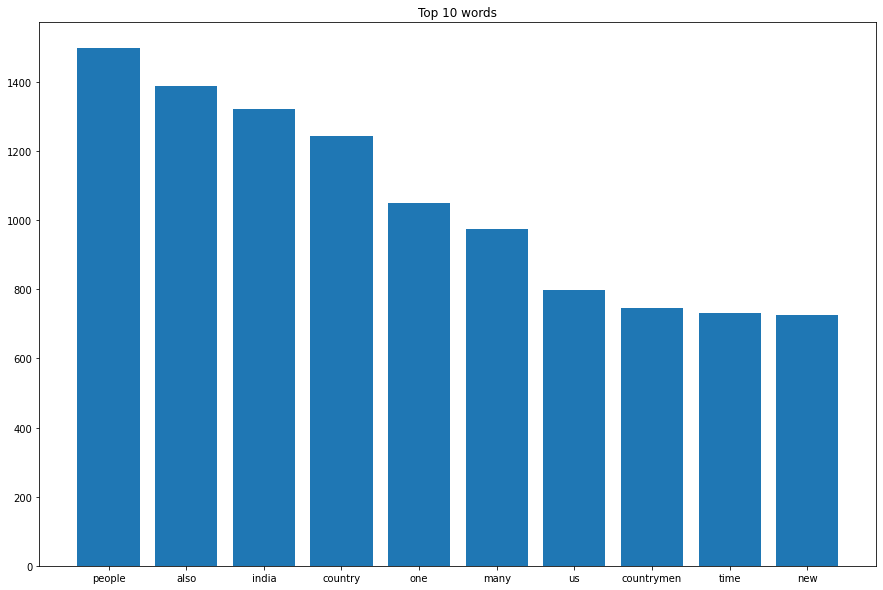

In [ ]:
plt.figure(figsize = (15,10))
plt.bar(common_words['Word'],common_words['Frequency'])
plt.title("Top 10 words")
plt.show()

POS Tagging

In [ ]:

from textblob import TextBlob
import pandas as pd

df = pd.read_csv('MKB.csv')

string = ""
for i, r in df.iterrows():
  string += r['Content'] + " " 

len(string)


1793455

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

blob = TextBlob(string)
df1 = pd.DataFrame()
words = []
tags = []
x = blob.tags
for i in x:
  words.append(i[0])
  tags.append(i[1])

df1['word'] = words
df1['tag'] = tags

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


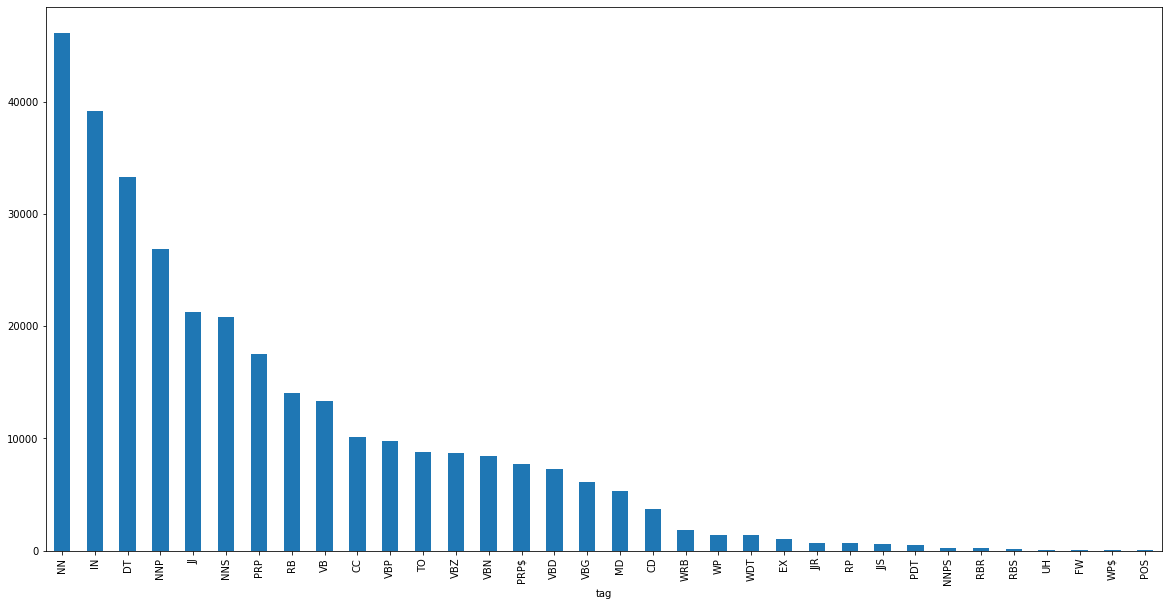

In [ ]:
df1.head()

s1 = df1.groupby('tag')['word'].count().sort_values(ascending = False)
s1.plot.bar(figsize=(20,10))

### Twitter

Language Tagging

In [ ]:
def get_big_df( file_name ):
  file = open( file_name )
  data = json.loads(file.read())
  
  df = pd.DataFrame.from_dict(data, orient='index')

  df.head()

  data['--']
  del data['--']
  dates = list(data.keys())

  dfs = {}
  for i in dates:
    df = pd.DataFrame.from_dict(data[i], orient='index')
    ids = []
    epi_dates = []
    for j, r in df.iterrows():
      ids.append(r.name)
      epi_dates.append(i)
    df['id'] = ids
    df['date'] = epi_dates
    df.columns = ['content', 'id', 'date']
    dfs[i] = df

  big_df = dfs[dates[0]]
  for i in range(1, len(dates)):
    big_df = big_df.append(dfs[dates[i]])

  big_df = big_df[['id', 'date', 'content']]
  return big_df


df=get_big_df('tweets48.json')



In [ ]:
def get_info(tweet,prev_count):
  hindi=prev_count[0]
  english=prev_count[1]
  hashtag=prev_count[2]
  mention=prev_count[3]
  for i in (tweet.split()):
    if '#' in i:
      prev_count[2]+=1
    elif '@' in i:
      prev_count[3]+=1
    elif re.sub(r'[^a-zA-Z0-9]', '', i).isascii() and re.sub(r'[^a-zA-Z0-9]', '', i).isalnum(): #removes all non alphanumeric
      prev_count[1]+=1
    else:
      prev_count[0]+=1
    
    
    
  #print(tweet.split())
  return prev_count

In [ ]:


df.iloc[0][2]
df2=df



In [ ]:
mydict={}
rows,cols=df2.shape

for i in range(0,rows):
  date=df2.iloc[i][1]
  if date in mydict.keys():
   
    mydict[date]=get_info(df2.iloc[i][2],mydict[date])
  else:
    mydict[date]=[0,0,0,0]
    mydict[date]=get_info(df2.iloc[i][2],mydict[date])

In [ ]:
finaldf=pd.DataFrame.from_dict(mydict, orient='index',columns=['hindi','english','hash','mention'])
finaldf

,hindi,english,hash,mention
2021-10-24,25457,18575,3417,2051
2021-09-26,14211,17479,2929,1164
2021-08-29,13494,20779,3629,2066
2021-07-25,10099,24819,2952,3182
2021-06-27,18512,20848,3787,2920
...,...,...,...,...
2015-02-22,10482,19520,3297,1043
2015-01-27,4267,21958,3747,1202
2014-12-14,8181,19621,4308,1069
2014-11-02,7116,21972,3475,1297


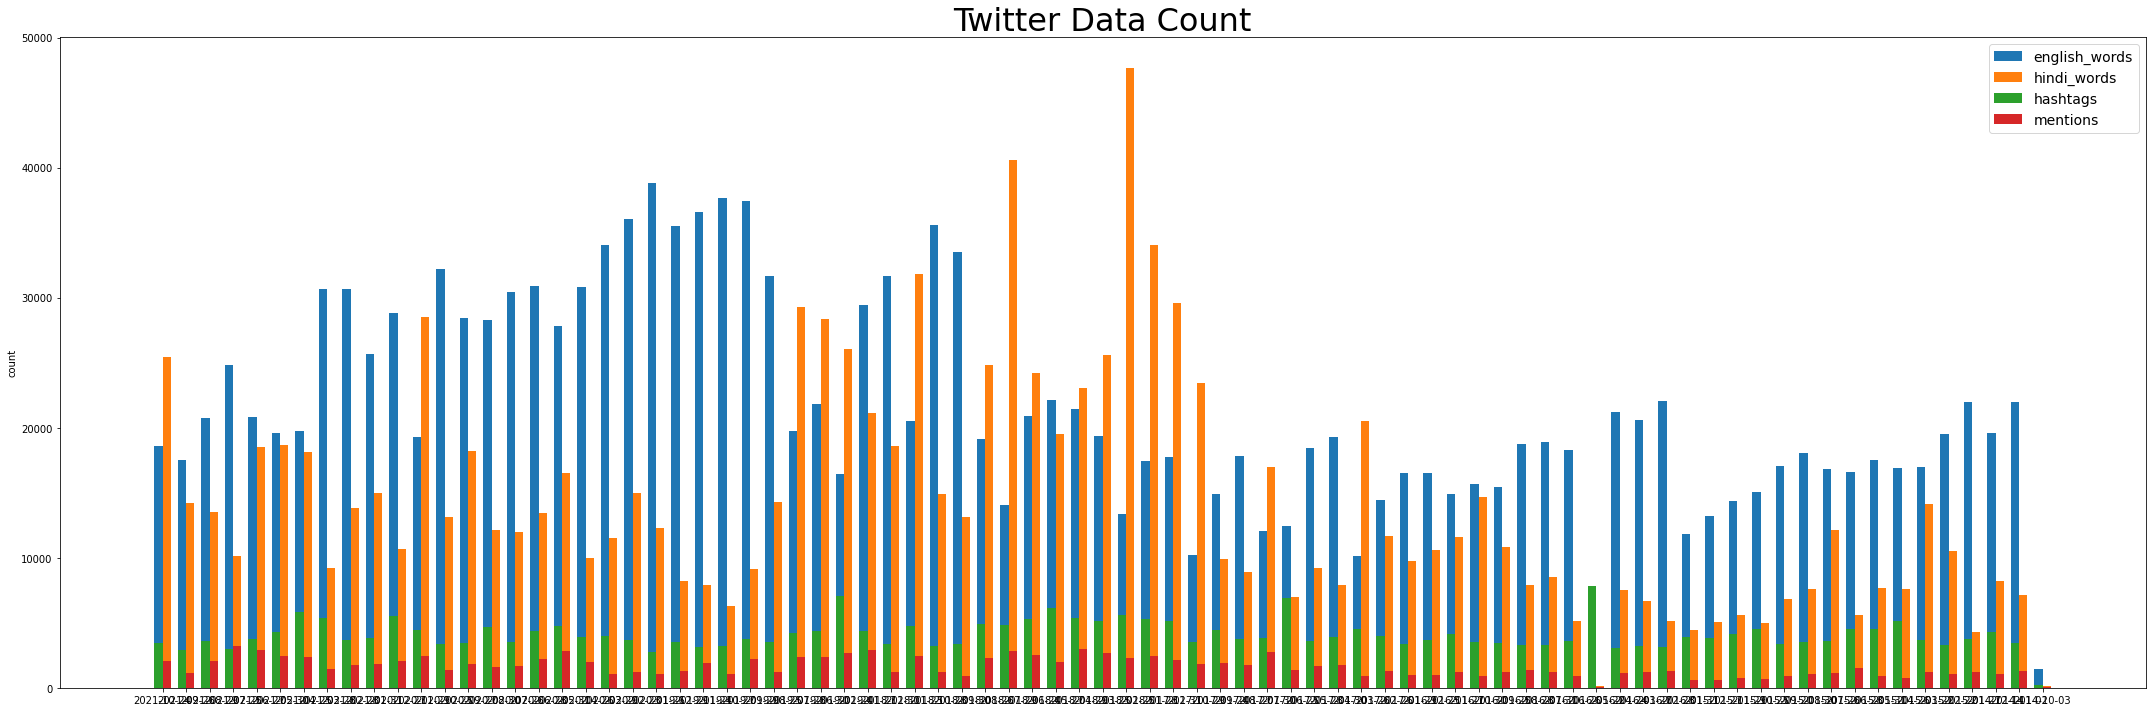

In [ ]:


import matplotlib.pyplot as plt
import numpy as np


labels = finaldf.index
english_words = finaldf['english'].tolist()
hindi_words = finaldf['hindi'].tolist()
hashtags = finaldf['hash'].tolist()
mentions = finaldf['mention'].tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30,10))
rects1 = ax.bar(x - width/2, english_words, width, label='english_words')
rects2 = ax.bar(x + width/2, hindi_words, width, label='hindi_words')
rects3 = ax.bar(x - width/2, hashtags, width, label='hashtags')
rects3 = ax.bar(x + width/2, mentions, width, label='mentions')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_title('Twitter Data Count',fontsize = 32)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize = 14)



fig.tight_layout()

plt.show()
fig.set_size_inches(30, 10.5)
fig.savefig('twitter_data.png', dpi=100)



Word Frequency

In [ ]:
df = pd.read_csv( 'cleaned_tweets48.csv')

In [ ]:
df = df.drop('Unnamed: 0', 1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,id,date,content
0,1452749734716661762,2021-10-24,mannkibaat via namo app
1,1452725732002697219,2021-10-24,mannkibaat pmmodi mygovindia stand india gover...
2,1452720861367078912,2021-10-24,local mannkibaat httpstcoagncronqjh
3,1452720388371357699,2021-10-24,javedmansari langamahesh nobody bjp would want...
4,1452713887451607044,2021-10-24,listened hon pm shrinarendramodi ji mannkibaat...


In [ ]:


def remove_newlines_tabs_multispaces( string ):
  new_string = ""
  for i in string:
    if i != '\n':
      new_string += i
    else:
      new_string += ' '
  
  string = ""
  for i in new_string:
    if i != '\t':
      string += i
    else:
      string += ' '
  
  new_string = ""
  for i in range(len(string)-1):
    if( string[i] != ' ' ):
      new_string += string[i]
    else:
      if string[i+1] == ' ':
        continue
      else:
        new_string += string[i]
  return new_string



In [ ]:


def word_frequency_table( paragraph ):
  paragraph = remove_newlines_tabs_multispaces( paragraph )
  words = paragraph.strip().split(' ')
  wft = {}
  to_remove = ["mannkibaat", "narendramodi", "pm", "modi", "via", "app", "namo", "amp", "rt", "ji", "ki"]
  for i in words:
    if i in to_remove:
      continue
    if "http" in i:
      continue
    if i in wft.keys():
      wft[i] += 1
    else:
      wft[i] = 1
  
  df = pd.DataFrame()
  df = pd.DataFrame.from_dict(wft, orient='index')
  return df



In [ ]:


paragraph = ""
for i, r in df.iterrows():
  paragraph += " " + r['content']


wft = word_frequency_table(paragraph)
wft.columns = ['count']
wft = wft.sort_values(by=['count'], ascending=False)
wft

,count
india,16058
pmoindia,11720
people,5935
narendra,4950
baat,4581
...,...
typenoof,1
jaybhadrakali,1
wordsslay,1
usake,1


In [ ]:
wft15 = wft.head(30)
wft15

,count
india,16058
pmoindia,11720
people,5935
narendra,4950
baat,4581
today,4249
world,3911
mann,3596
nation,3569
country,3544


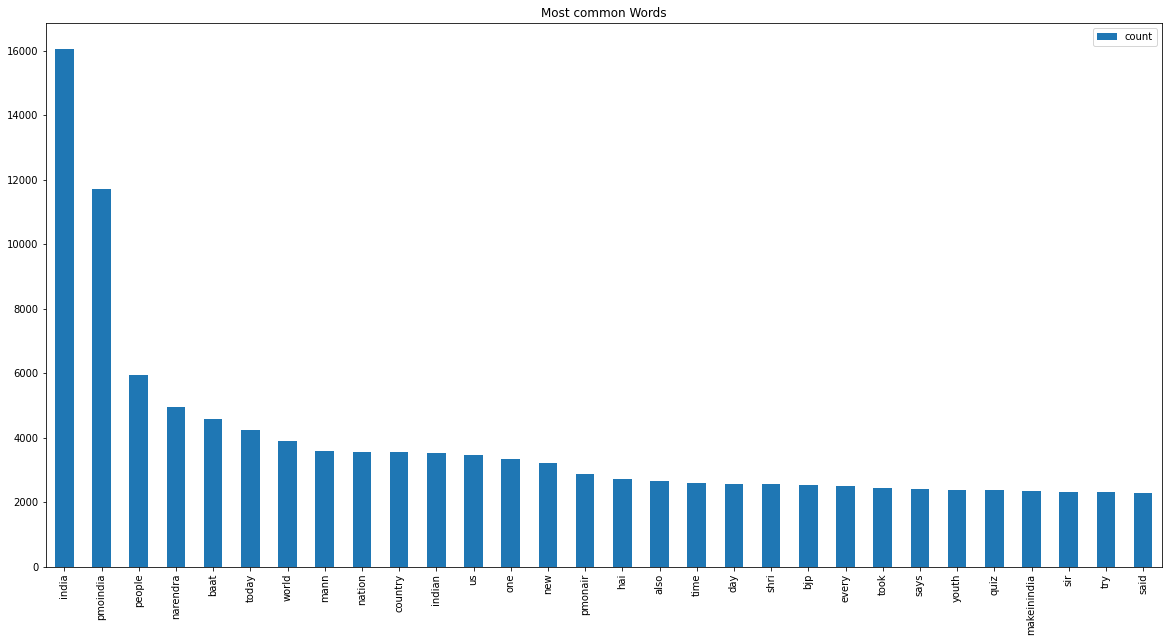

In [ ]:
import matplotlib.pyplot as plt
wft15.plot.bar(figsize=(20,10)).set(title = "Most common Words")
plt.show()

# Hypothesis Testing

In [ ]:
mkb = pd.read_csv('MKB.csv')
tweets = pd.read_csv('cleaned_tweets48.csv')

In [ ]:
mkb.head()

,Episode,Content,Views,Likes,Dislikes,Cleaned_content,Total_words,Words_without_stop,Year
0,20211024,"My dear countrymen,\nNamaskar…namaskar a billi...",24394,1799,627,dear countrymen namaskar namaskar billion time...,4904,3014,2021
1,20210926,"My dear countrymen,\nNamaskar. You are aware t...",22728,1310,490,dear countrymen namaskar aware important progr...,4266,2564,2021
2,20210829,"My dear countrymen, Namaskar.\nAll of us know ...",12047,416,1156,dear countrymen namaskar us know today birth a...,4579,2799,2021
3,20210725,"My dear countrymen, Namaskar. A few amazing pi...",50659,2332,5577,dear countrymen namaskar amazing pictures take...,4510,2782,2021
4,20210627,"My dear countrymen, Namaskar.\nOften in Mann K...",71155,1828,11115,dear countrymen namaskar often mann ki baat vo...,5572,3451,2021


In [ ]:
tweets

,Unnamed: 0,id,date,content
0,1452749734716661762,1452749734716661762,2021-10-24,mannkibaat via namo app
1,1452725732002697219,1452725732002697219,2021-10-24,mannkibaat pmmodi mygovindia stand india gover...
2,1452720861367078912,1452720861367078912,2021-10-24,local mannkibaat httpstcoagncronqjh
3,1452720388371357699,1452720388371357699,2021-10-24,javedmansari langamahesh nobody bjp would want...
4,1452713887451607044,1452713887451607044,2021-10-24,listened hon pm shrinarendramodi ji mannkibaat...
...,...,...,...,...
160183,517902912857460737,517902912857460737,2014-10-03,billion population get hear modi air oath cere...
160184,517900645626421248,517900645626421248,2014-10-03,live streaming narendramodi speech mannkibaat ...
160185,517900128561004544,517900128561004544,2014-10-03,rj namo mannkibaat airnewsalerts
160186,517881722302513152,517881722302513152,2014-10-03,listen mannkibaat stations narendramodi


In [ ]:
def remove_newlines_tabs_multispaces( string ):
  new_string = ""
  for i in string:
    if i != '\n':
      new_string += i
    else:
      new_string += ' '
  
  string = ""
  for i in new_string:
    if i != '\t':
      string += i
    else:
      string += ' '
  
  new_string = ""
  for i in range(len(string)-1):
    if( string[i] != ' ' ):
      new_string += string[i]
    else:
      if string[i+1] == ' ':
        continue
      else:
        new_string += string[i]
  return new_string
def word_frequency_table( paragraph ):
  # paragraph = remove_newlines_tabs_multispaces( paragraph )
  words = paragraph.strip().split(' ')
  wft = {}
  to_remove = ["mannkibaat", "narendramodi", "pm", "modi", "via", "app", "namo", "amp", "rt", "ji", "ki", "also"]
  for i in words:
    if i in to_remove:
      continue
    if "http" in i:
      continue
    if i in wft.keys():
      wft[i] += 1
    else:
      wft[i] = 1

  return wft

text = ""
for i,r in mkb.iterrows():
  text += (r['Cleaned_content'])

wf_mkb = word_frequency_table(text)

text = ""
for i,r in tweets.iterrows():
  text += (r['content'])

wf_tweets = word_frequency_table(text)

In [ ]:
wf_mkb_top30 = {k: v/ len(wf_mkb) for k, v in sorted(wf_mkb.items(), key=lambda item: item[1], reverse=True)[1:31]}
wf_mkb_top30

{'baat': 0.028894713290289586,
 'come': 0.026273732659975707,
 'country': 0.07958831426197022,
 'countrymen': 0.0476890622003452,
 'day': 0.03483986447612351,
 'dear': 0.034200600907754265,
 'even': 0.02563446909160647,
 'every': 0.0366937288243943,
 'friends': 0.0350955699034712,
 'get': 0.028830786933452663,
 'government': 0.02895863964712651,
 'india': 0.08444671738157643,
 'know': 0.02915041871763728,
 'life': 0.03477593811928658,
 'like': 0.036054465256025056,
 'mann': 0.028702934219778816,
 'many': 0.06232819791600077,
 'must': 0.02991753499968037,
 'new': 0.04641053506360673,
 'one': 0.06705874832193313,
 'people': 0.09576168254171195,
 'time': 0.04673016684779135,
 'today': 0.036821581538068145,
 'us': 0.051077159112702164,
 'water': 0.02684906987150802,
 'way': 0.026401585373649554,
 'world': 0.041935690085022057,
 'would': 0.04116857380297897,
 'year': 0.026081953589464937,
 'years': 0.025762321805280316}

In [ ]:
wf_tweets_top30 = {}
for i in wf_mkb_top30.keys():
  if i in wf_tweets.keys():
    wf_tweets_top30[i] = wf_tweets[i] / len(wf_tweets)
  else:
    wf_tweets_top30[i] = 0

In [ ]:
wf_tweets_top30

{'baat': 0.0588787208883862,
 'come': 0.010989152228677189,
 'country': 0.04555035730810755,
 'countrymen': 0.003624492314019845,
 'day': 0.03312169040152177,
 'dear': 0.007814508251503779,
 'even': 0.017017119942419414,
 'every': 0.031964937535345225,
 'friends': 0.004125751889363015,
 'get': 0.017788288519870445,
 'government': 0.011888848902370058,
 'india': 0.2063904169451442,
 'know': 0.0170299727520436,
 'life': 0.020731581923808546,
 'like': 0.027813480026733842,
 'mann': 0.04621870340856511,
 'many': 0.0262582900622076,
 'must': 0.019639093105752917,
 'new': 0.04130893013212688,
 'one': 0.042979795383270784,
 'people': 0.07628142511953113,
 'time': 0.033455863451750556,
 'today': 0.054611588093157165,
 'us': 0.04438075163230682,
 'water': 0.025847000154233715,
 'way': 0.012660017479821088,
 'world': 0.050267338440183024,
 'would': 0.012351550048840677,
 'year': 0.025744177677240243,
 'years': 0.024381779857076756}

In [ ]:
import plotly.graph_objects as go
def plot_bar_graph(xs, ys, names, xlabel, ylabel, title):# create figure object
    fig = go.Figure()# create bar chart for each of the series provided 
    for (x, y), name in zip(zip(xs, ys), names):fig.add_trace(go.Bar(x=x, y=y, name=name, orientation='v'))# Here we modify the tickangle of the xaxis, resulting in rotated labels.
    fig.update_layout(
        barmode='group',
        autosize=False,
        width=1300,
        height=500,
        margin=dict(l=5, r=5, b=5, t=50, pad=5),
        xaxis={'type': 'category', 'title': xlabel},
        yaxis_title=ylabel,
        title=title
    )
    fig.show()

plot_bar_graph([[k for k in wf_mkb_top30.keys()], [k for k in wf_tweets_top30.keys()]], [[v for k,v in wf_mkb_top30.items()], [v for k,v in wf_tweets_top30.items()]], ["mkb","twitter"], "Words", "Frequency", "Frequency of Words across Targets")

In [ ]:
data1 = list(wf_mkb_top30.values())
data1

[0.09576168254171195,
 0.08444671738157643,
 0.07958831426197022,
 0.06705874832193313,
 0.06232819791600077,
 0.051077159112702164,
 0.0476890622003452,
 0.04673016684779135,
 0.04641053506360673,
 0.041935690085022057,
 0.04116857380297897,
 0.036821581538068145,
 0.0366937288243943,
 0.036054465256025056,
 0.0350955699034712,
 0.03483986447612351,
 0.03477593811928658,
 0.034200600907754265,
 0.02991753499968037,
 0.02915041871763728,
 0.02895863964712651,
 0.028894713290289586,
 0.028830786933452663,
 0.028702934219778816,
 0.02684906987150802,
 0.026401585373649554,
 0.026273732659975707,
 0.026081953589464937,
 0.025762321805280316,
 0.02563446909160647]

In [ ]:
data2 = list(wf_tweets_top30.values())
data2

[0.07628142511953113,
 0.2063904169451442,
 0.04555035730810755,
 0.042979795383270784,
 0.0262582900622076,
 0.04438075163230682,
 0.003624492314019845,
 0.033455863451750556,
 0.04130893013212688,
 0.050267338440183024,
 0.012351550048840677,
 0.054611588093157165,
 0.031964937535345225,
 0.027813480026733842,
 0.004125751889363015,
 0.03312169040152177,
 0.020731581923808546,
 0.007814508251503779,
 0.019639093105752917,
 0.0170299727520436,
 0.011888848902370058,
 0.0588787208883862,
 0.017788288519870445,
 0.04621870340856511,
 0.025847000154233715,
 0.012660017479821088,
 0.010989152228677189,
 0.025744177677240243,
 0.024381779857076756,
 0.017017119942419414]

In [ ]:
# generate gaussian data samples
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
# summarize
print('data1: mean=%.3f stdv=%.3f' % (mean(data1), std(data1)))
print('data2: mean=%.3f stdv=%.3f' % (mean(data2), std(data2)))

data1: mean=0.041 stdv=0.018
data2: mean=0.035 stdv=0.036


# Mann-Whitney U Test
The Mann-Whitney U test is a non-parametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

The test was named for Henry Mann and Donald Whitney, although it is sometimes called the Wilcoxon-Mann-Whitney test, also named for Frank Wilcoxon, who also developed a variation of the test.

The two samples are combined and rank ordered together. The strategy is to determine if the values from the two samples are randomly mixed in the rank ordering or if they are clustered at opposite ends when combined. A random rank order would mean that the two samples are not different, while a cluster of one sample values would indicate a difference between them.

— Page 58, Nonparametric Statistics for Non-Statisticians: A Step-by-Step Approach, 2009.

**H0 : Null Hypothesis** : The relationship between Mann-ki-baat and Twitter data is purely by chance.

**H1 : Alternative Hypothesis** : There might be some relationship between Mann-ki-baat and Twitter data. This has to be further studied using Machine Learning techniques

In [ ]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('fail to reject H0')
else:
	print('reject H0')

Statistics=283.000, p=0.007
reject H0


## Topic Modelling using LDA

In [ ]:
def load():
    df = pd.read_csv("MKB.csv")
    for i in range(0, 5):
        topic(df, i)

In [ ]:
def topic(df1,k):
    print(k)
    p = figure(title="Graphical representation of Topics", x_axis_label='Topic', y_axis_label='Value',plot_width=400 , plot_height = 400)
    valuelist = []
    strlist = []
    tokens = []
    lemmatized = []
    c = 0
    speech = df1['Cleaned_content'][k]
    blob = TextBlob(speech)
    noun =  blob.noun_phrases
    stemmer = PorterStemmer()
    sent= [w for w in sent_tokenize(speech.lower())]
    for i in range(0, len(sent)):
        tokens.append([w for w in word_tokenize(sent[i].lower()) if w.isalpha() and w not in STOPWORDS and not len(w)<=2 and w not in stop and w not in noun])
    for i in tokens:
        lemm = [wordnet_lemmatizer.lemmatize(t) for t in i]
        lemmatized.append(lemm)
    dictionary = Dictionary(lemmatized)
    corpus = [dictionary.doc2bow(doc) for doc in lemmatized]
    '''tfidf = TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus[0]]
    sorted_tfidf = sorted(corpus_tfidf, key=lambda w: w[1], reverse=True)
    for term_id, weight in sorted_tfidf:
        strlist.append(dictionary.get(term_id))
        valuelist.append(weight)'''
    #print(strlist)
    #print(valuelist)
    #plt.barh(strlist, valuelist)
    #plt.show()
    t = 0
    lda_model = gensim.models.LdaMulticore(corpus,num_topics=10, id2word=dictionary, passes=2)
    K = lda_model.num_topics
    topicWordProbMat = sorted(lda_model.print_topics(K), key=lambda tup: tup[1], reverse=True)
    for line in topicWordProbMat:
           tp, w = line
           probs = w.split("+")
           y=0
           for pr in probs:
                #print(pr)
                a = pr.split("*")
                #print(a)
                valuelist.append(float(a[0]))
                y += 1
                strlist.append(a[1])
                c = c + 1
                #yr = str(df1['year'][k])
                #mon = str(df1['month'][k])
                ep = str(df1['Episode'][k])
                plt.title(ep)
                
                plt.xlabel("Value")
                plt.ylabel("Topic")
                if(c>10):
                    break
    #print(valuelist)
    #print(strlist)
    plt.barh(strlist,valuelist,color='r')
    plt.show()
    '''
    p.hbar(y=valuelist,
           height=0.1,
           left=0,
           right=strlist,
           color="navy")
    #p.xgrid.grid_line_color = None
    #p.y_range.start = 0
    '''
    #layout = row(p)
    #show(layout)

0


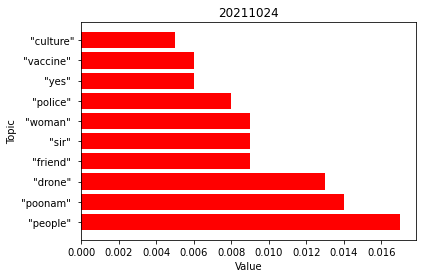

1


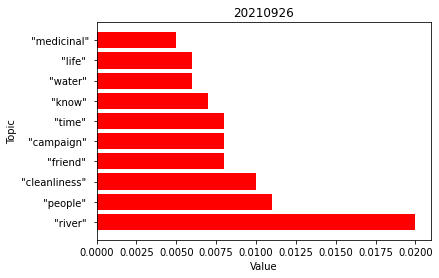

2


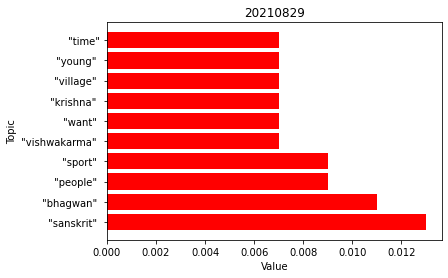

3


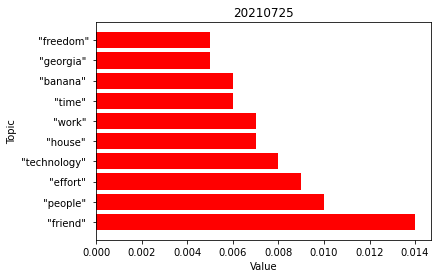

4


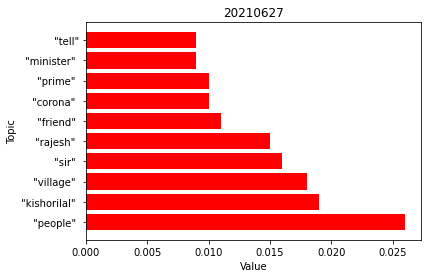

In [ ]:
load()

In [ ]:
def word_freq(text, word):
  textToken = nltk.word_tokenize(text)
  #print(textToken)
  counts = nltk.FreqDist(textToken)
  #print(counts[word])
  #print(counts[word]/len(textToken))
  return [counts[x]/len(textToken) for x in word]

In [ ]:
def df_wf():
  df = pd.read_csv('MKB.csv')
  ls = []
  for i in range(len(df)):
    temp = word_freq(df['Cleaned_content'][i], ["farmer", "corona","lockdown"])
    ls.append([df['Episode'][i], temp])
  
  return ls

In [ ]:
myLS = df_wf()
myLS

[[20211024, [0.0, 0.0004415011037527594, 0.0]],
 [20210926, [0.0, 0.001514386673397274, 0.0]],
 [20210829, [0.0, 0.00044072278536800354, 0.0]],
 [20210725, [0.0, 0.0014091122592766556, 0.0]],
 [20210627, [0.0, 0.008339952343129467, 0.0]],
 [20210530, [0.0, 0.007988380537400145, 0.00036310820624546115]],
 [20210425, [0.0, 0.009651699538396978, 0.0]],
 [20210328, [0.0, 0.001968503937007874, 0.0]],
 [20210228, [0.0005027652086475615, 0.003519356460532931, 0.0]],
 [20210131, [0.0, 0.0037313432835820895, 0.0005330490405117271]],
 [20201227, [0.0, 0.0028702640642939152, 0.0]],
 [20201129,
  [0.0046415678184631255, 0.0036101083032490976, 0.0005157297576070139]],
 [20201025,
  [0.0004803073967339097, 0.0009606147934678194, 0.0024015369836695487]],
 [20200927,
  [0.003955696202531646, 0.0015822784810126582, 0.0007911392405063291]],
 [20200830,
  [0.0005274261603375527, 0.0031645569620253164, 0.0010548523206751054]],
 [20200726, [0.0, 0.005112072355485647, 0.0]],
 [20200628,
  [0.000982318271119

In [ ]:
df2 = pd.DataFrame(myLS)
df3 = pd.DataFrame(df2[1].to_list(), columns=["farmer", "corona","lockdown"])
df3["farmer"] = df3["farmer"].apply(lambda x: x*x)
df3["corona"] = df3["corona"].apply(lambda x: x*x)
df3["lockdown"] = df3["lockdown"].apply(lambda x: x*x)

In [ ]:
df3

,farmer,corona,lockdown
0,0.0,1.949232e-07,0.0
1,0.0,2.293367e-06,0.0
2,0.0,1.942366e-07,0.0
3,0.0,1.985597e-06,0.0
4,0.0,6.955481e-05,0.0
...,...,...,...
76,0.0,0.000000e+00,0.0
77,0.0,0.000000e+00,0.0
78,0.0,0.000000e+00,0.0
79,0.0,0.000000e+00,0.0


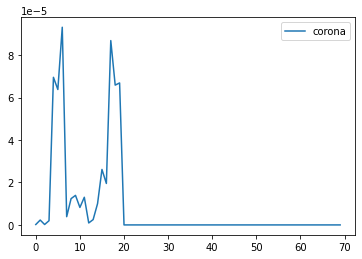

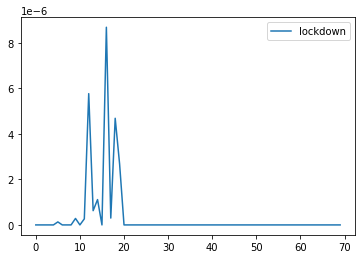

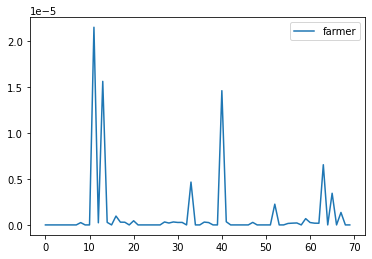

In [ ]:
df3.iloc[:70].plot(y=1)
df3.iloc[:70].plot(y=2)
df3.iloc[:70].plot(y=0)

In [ ]:
test_df = pd.read_csv('cleaned_tweets48.csv')
test_df

,Unnamed: 0,id,date,content
0,1452749734716661762,1452749734716661762,2021-10-24,mannkibaat via namo app
1,1452725732002697219,1452725732002697219,2021-10-24,mannkibaat pmmodi mygovindia stand india gover...
2,1452720861367078912,1452720861367078912,2021-10-24,local mannkibaat httpstcoagncronqjh
3,1452720388371357699,1452720388371357699,2021-10-24,javedmansari langamahesh nobody bjp would want...
4,1452713887451607044,1452713887451607044,2021-10-24,listened hon pm shrinarendramodi ji mannkibaat...
...,...,...,...,...
160183,517902912857460737,517902912857460737,2014-10-03,billion population get hear modi air oath cere...
160184,517900645626421248,517900645626421248,2014-10-03,live streaming narendramodi speech mannkibaat ...
160185,517900128561004544,517900128561004544,2014-10-03,rj namo mannkibaat airnewsalerts
160186,517881722302513152,517881722302513152,2014-10-03,listen mannkibaat stations narendramodi


In [ ]:
test_df.drop('Unnamed: 0', axis = 1,inplace = True)
my_df = list(test_df.groupby('date')['content'])
my_df = pd.DataFrame(my_df)

In [ ]:
tweets_wf = {}
new_tweets = test_df.groupby('date')['content'].apply(list)
for r in new_tweets.index:
  tweets_wf[r] = " ".join(new_tweets[r])
#tweets_wf

In [ ]:
t = []
for k,v in tweets_wf.items():
  t.append([k,v])

In [ ]:
my_df = pd.DataFrame(t)

In [ ]:
my_df = my_df.rename(columns={0:'date',1:'ep'})

In [ ]:
def df_wf_t(df):
  #df = pd.read_csv('MKB.csv')
  ls = []
  for i in range(len(df)):
    temp = word_freq(df['ep'][i], ["farmer", "corona","lockdown"])
    ls.append([df['date'][i], temp])
  
  return ls


In [ ]:
tweet_ls = df_wf_t(my_df)

In [ ]:
df4 = pd.DataFrame(tweet_ls)
df5 = pd.DataFrame(df4[1].to_list(), columns=["farmer", "corona","lockdown"])

In [ ]:
df5 = df5[::-1].reset_index(drop=True)

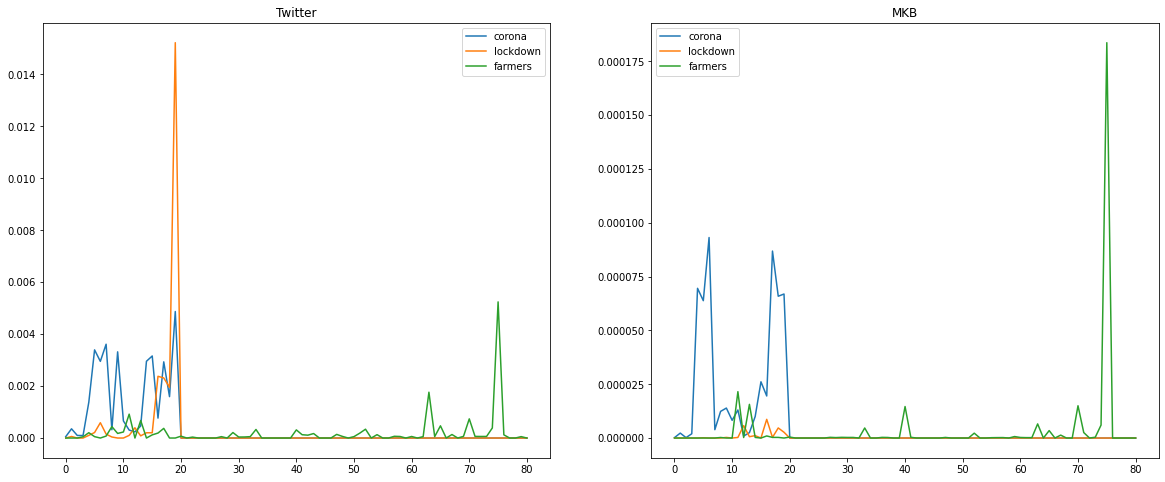

In [ ]:
fig = plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.plot(df5['corona'])
plt.plot(df5['lockdown'])
plt.plot(df5['farmer'])
plt.legend(['corona','lockdown','farmers'])
plt.title("Twitter")

plt.subplot(1, 2, 2)
plt.plot(df3['corona'])
plt.plot(df3['lockdown'])
plt.plot(df3['farmer'])
plt.legend(['corona','lockdown','farmers'])
plt.title("MKB")


plt.show()

## Sentiment Analysis 

In [ ]:
!pip3 install textblob

In [ ]:
from textblob import TextBlob
df = pd.read_csv('MKB.csv')
polarities = []
subjectivities = []

for i,r in df.iterrows():
  blob = TextBlob(r['Content'])
  polarities.append(blob.sentiment.polarity)
  subjectivities.append(blob.sentiment.subjectivity)

df['polarity'] = polarities
df['subjectivity'] = subjectivities

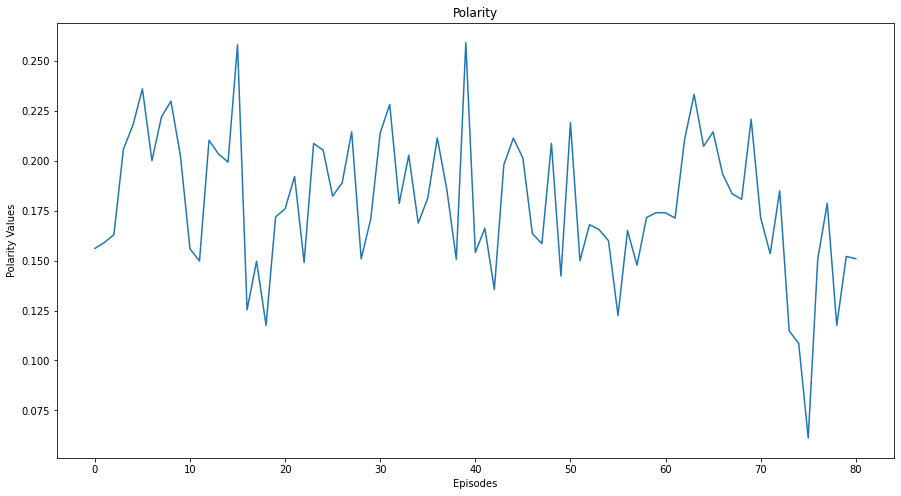

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.title('Polarity')
plt.plot(df['polarity'])
plt.xlabel("Episodes")
plt.ylabel("Polarity Values")
#plt.legend()
plt.show()

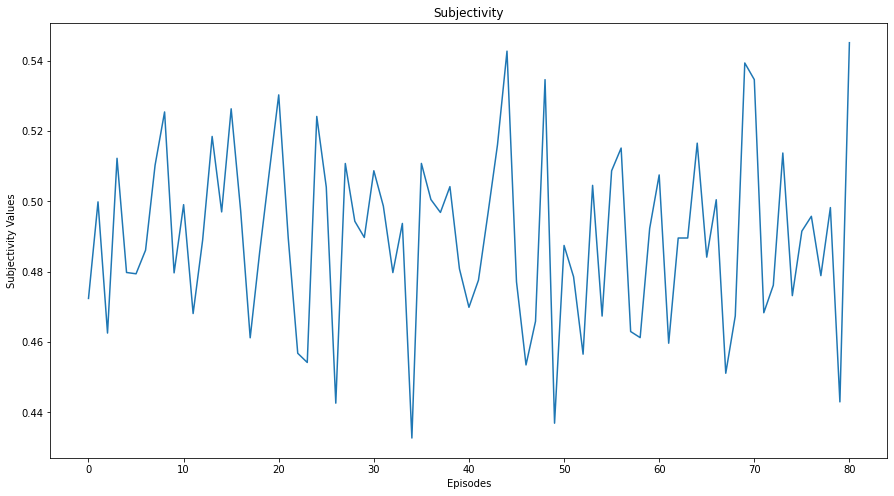

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df['subjectivity'], label = ['Subjectivity'])
#plt.plot(df['polarity'],label = ['Polarity'])
plt.title("Subjectivity")
plt.xlabel("Episodes")
plt.ylabel("Subjectivity Values")
#plt.legend()
plt.show()